## Imports and dataset

In [8136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

### Dataset:
IRON WOLF. (2024). *Laptop Price - dataset* [Data set]. 
Kaggle. https://www.kaggle.com/datasets/ironwolf437/laptop-price-dataset?resource=download


In [8137]:
dataset_cols = [
    "company",
    "product",
    "type",
    "inches",
    "screen_res",
    "cpu_company",
    "cpu_type",
    "cpu_speed",
    "ram",
    "memory",
    "gpu_company",
    "gpu_type",
    "weight",
    "price"
]
df = pd.read_csv("data/laptop_price - dataset.csv").drop(["OpSys"], axis=1)

In [8138]:
df.columns = dataset_cols

In [8139]:
df.head()

,company,product,type,inches,screen_res,cpu_company,cpu_type,cpu_speed,ram,memory,gpu_company,gpu_type,weight,price
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3,8,128GB SSD,Intel,Iris Plus Graphics 640,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel,Core i5,1.8,8,128GB Flash Storage,Intel,HD Graphics 6000,1.34,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel,Core i5 7200U,2.5,8,256GB SSD,Intel,HD Graphics 620,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel,Core i7,2.7,16,512GB SSD,AMD,Radeon Pro 455,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel,Core i5,3.1,8,256GB SSD,Intel,Iris Plus Graphics 650,1.37,1803.60


In [8140]:
# remove unpredictory data
df = df.drop(['product'], axis=1)

### Clean Data and preprocessing

#### Numerical and categoricals splitting values for screen_res

In [8141]:
def clean_screen_resolution(df):
    
    res = df['screen_res'].str.extract(r'(\d+)\s*x\s*(\d+)', expand=True)

    # makes x and y res for numerical sake for better model
    df['x_res'] = res[0].astype(float)
    df['y_res'] = res[1].astype(float)

    # pixels per inch
    df['ppi'] = np.sqrt(df['x_res']**2 + df['y_res']**2) / df['inches']

    df['touchscreen'] = df['screen_res'].apply(
        lambda x: 1 if 'touch' in x.lower() else 0
    )

    
    def get_panel_type(text):
        if not isinstance(text, str):
            return 'ips'
        text = text.lower()
        if 'ips' in text:
            return 'ips'
        elif 'retina' in text:
            return 'retina'
        elif 'oled' in text:
            return 'oled'
        else:
            return 'ips'

    df['panel_type'] = df['screen_res'].apply(get_panel_type)

    df = df.drop(["screen_res"], axis=1)    

    return df


In [8142]:

df = clean_screen_resolution(df)

In [8143]:
df.sample(5)

,company,type,inches,cpu_company,cpu_type,cpu_speed,ram,memory,gpu_company,gpu_type,weight,price,x_res,y_res,ppi,touchscreen,panel_type
257,HP,Notebook,17.3,Intel,Core i7 8550U,1.8,16,1TB HDD,Nvidia,GeForce MX150,2.90,1059.00,1920.0,1080.0,127.335675,0,ips
690,Acer,Notebook,14.0,Intel,Celeron Dual Core 3855U,1.6,4,32GB Flash Storage,Intel,HD Graphics 510,1.45,375.00,1366.0,768.0,111.935204,0,ips
417,HP,Ultrabook,14.0,Intel,Core i7 6500U,2.5,8,256GB SSD,Intel,HD Graphics 520,1.43,1500.00,1920.0,1080.0,157.350512,0,ips
843,Dell,Notebook,15.6,Intel,Core i5 7200U,2.5,8,128GB SSD,Intel,HD Graphics 620,2.18,713.99,1366.0,768.0,100.454670,0,ips
730,Acer,Gaming,17.3,Intel,Core i7 6700HQ,2.6,16,128GB SSD + 1TB HDD,Nvidia,GeForce GTX 1060,4.20,1935.00,1920.0,1080.0,127.335675,0,ips


#### Numerical values for memory

In [8144]:

def clean_memory(df):
    df['memory'] = df['memory'].str.lower()

    # tb to gb
    df['memory'] = df['memory'].str.replace(
        r'(\d+(?:\.\d+)?)\s*tb',
        lambda m: f"{int(float(m.group(1)) * 1024)}gb",
        regex=True
    )

    df['ssd_gb'] = (
        df['memory']
        .str.findall(r'(\d+)\s*gb\s*(?:ssd|flash)')
        .apply(lambda x: int(x[0]) if x else 0)
    )

    # --- HDD ---
    df['hdd_gb'] = (
        df['memory']
        .str.findall(r'(\d+)\s*gb\s*hdd')
        .apply(lambda x: int(x[0]) if x else 0)
    )

    df = df.drop(['memory'], axis=1)
    return df



In [8145]:
df = clean_memory(df)

In [8146]:
df['total_memory'] = df['ssd_gb'] + df['hdd_gb']

In [8147]:
df.sample(5)

,company,type,inches,cpu_company,cpu_type,cpu_speed,ram,gpu_company,gpu_type,weight,price,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,hdd_gb,total_memory
149,Acer,Notebook,15.6,Intel,Core i3 6006U,2.0,4,Intel,HD Graphics 520,2.1,447.0,1366.0,768.0,100.454670,0,ips,0,1024,1024
607,Lenovo,Notebook,15.6,Intel,Core i5 7200U,2.5,6,Intel,HD Graphics 620,2.4,564.0,1920.0,1080.0,141.211998,0,ips,0,1024,1024
373,Lenovo,Notebook,17.3,AMD,A8-Series 7410,2.2,4,AMD,Radeon R5,2.6,489.0,1600.0,900.0,106.113062,0,ips,128,0,128
730,Acer,Gaming,17.3,Intel,Core i7 6700HQ,2.6,16,Nvidia,GeForce GTX 1060,4.2,1935.0,1920.0,1080.0,127.335675,0,ips,128,1024,1152
312,MSI,Gaming,15.6,Intel,Core i7 7700HQ,2.8,16,Nvidia,GeForce GTX 1070,2.8,2099.0,1920.0,1080.0,141.211998,0,ips,256,1024,1280


#### Clean cpu_type by only accepting series

In [8148]:
df['cpu_type'] = df['cpu_type'].str.strip().str.title()
df['cpu_series'] = df['cpu_type'].str.extract(r'([A-Za-z0-9\-]+ ?[iI]?\d?)')
df = df.drop(['cpu_type'], axis=1)


#### clean gpu_type by only extracting numbers

In [8149]:
df['gpu_model_num'] = df['gpu_type'].str.extract(r'(\d+)').astype(float)
# if nan
df['gpu_model_num'] = df['gpu_model_num'].fillna(df['gpu_model_num'].median())

df = df.drop(['gpu_type'], axis=1)


#### Turns out gpu_model_num was causing data leakage by being so few, it was telling the data during training the prices indirectly. Drop this

In [8150]:
df = df.drop(['gpu_model_num'], axis=1)

#### remove any low number of items that will hinder with model

In [8151]:
for col in df.columns:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())


company value counts:
company
Dell         291
Lenovo       289
HP           268
Asus         152
Acer         101
MSI           54
Toshiba       48
Apple         21
Samsung        9
Mediacom       7
Razer          7
Microsoft      6
Vero           4
Xiaomi         4
Chuwi          3
Fujitsu        3
Google         3
LG             3
Huawei         2
Name: count, dtype: int64

type value counts:
type
Notebook              707
Gaming                205
Ultrabook             194
2 in 1 Convertible    117
Workstation            29
Netbook                23
Name: count, dtype: int64

inches value counts:
inches
15.6    647
14.0    193
17.3    164
13.3    160
12.5     39
11.6     31
13.5      6
12.0      6
13.9      6
12.3      5
10.1      4
15.4      4
15.0      4
13.0      2
18.4      1
17.0      1
14.1      1
11.3      1
Name: count, dtype: int64

cpu_company value counts:
cpu_company
Intel      1214
AMD          60
Samsung       1
Name: count, dtype: int64

cpu_speed value counts:
cpu_

#### Removes any item with less than 2 entries

In [8152]:
df.columns

Index(['company', 'type', 'inches', 'cpu_company', 'cpu_speed', 'ram',
       'gpu_company', 'weight', 'price', 'x_res', 'y_res', 'ppi',
       'touchscreen', 'panel_type', 'ssd_gb', 'hdd_gb', 'total_memory',
       'cpu_series'],
      dtype='object')

In [8153]:
for col in df.columns:
  counts = df[col].value_counts()
  rare_values = counts[counts <= 2].index
  df = df[~df[col].isin(rare_values)]

In [8154]:
df.columns

Index(['company', 'type', 'inches', 'cpu_company', 'cpu_speed', 'ram',
       'gpu_company', 'weight', 'price', 'x_res', 'y_res', 'ppi',
       'touchscreen', 'panel_type', 'ssd_gb', 'hdd_gb', 'total_memory',
       'cpu_series'],
      dtype='object')

#### Copy df before encoding for better plot analysis

In [8155]:
cols = list(df.columns)
cols.remove('price')
cols.append('price')
df = df[cols]

df_plotting = df

#### Encoding categories

In [8156]:
df.head(10)

,company,type,inches,cpu_company,cpu_speed,ram,gpu_company,weight,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,hdd_gb,total_memory,cpu_series,price
16,Dell,Notebook,15.6,Intel,2.7,8,AMD,2.20,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I7,745.0
18,Lenovo,Notebook,15.6,Intel,2.4,8,Nvidia,2.20,1920.0,1080.0,141.211998,0,ips,0,1024,1024,Core I3,499.0
19,Dell,Ultrabook,13.3,Intel,1.6,8,Intel,1.22,1920.0,1080.0,165.632118,1,ips,128,0,128,Core I5,979.0
21,Lenovo,Gaming,15.6,Intel,2.5,8,Nvidia,2.50,1920.0,1080.0,141.211998,0,ips,128,1024,1152,Core I5,999.0
23,Dell,2 in 1 Convertible,13.3,Intel,1.6,8,Intel,1.62,1920.0,1080.0,165.632118,1,ips,256,0,256,Core I5,819.0
24,HP,Ultrabook,15.6,Intel,1.8,8,Intel,1.91,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I7,659.0
32,HP,Notebook,17.3,AMD,2.5,4,AMD,2.71,1920.0,1080.0,127.335675,0,ips,0,500,500,A6-Series 9,439.0
37,Dell,Notebook,17.3,Intel,1.6,8,AMD,2.80,1920.0,1080.0,127.335675,0,ips,128,1024,1152,Core I5,979.0
39,HP,Notebook,15.6,Intel,1.6,8,Nvidia,2.10,1920.0,1080.0,141.211998,0,ips,256,0,256,Core I5,879.0
40,Asus,Notebook,15.6,Intel,2.0,4,Intel,2.00,1920.0,1080.0,141.211998,0,ips,0,1024,1024,Core I3,389.0


In [8157]:
#Learned this way:

# # companies
# df = pd.get_dummies(df, dtype=int, columns=['company'], drop_first=True)

# #type
# df = pd.get_dummies(df, dtype=int, columns=['type'], drop_first=True)

# #cpu companies
# df = pd.get_dummies(df, dtype=int, columns=['cpu_company'], drop_first=True)

# #gpu companies
# df = pd.get_dummies(df, dtype=int, columns=['gpu_company'], drop_first=True)

# # panel type
# df = pd.get_dummies(df, dtype=int, columns=['panel_type'], drop_first=True)

# # cpu series
# df = pd.get_dummies(df, dtype=int, columns=['cpu_series'], drop_first=True)

#better way:
cat_cols = ['company', 'type', 'cpu_company', 'gpu_company', 'cpu_series']
df = pd.get_dummies(df, columns=cat_cols, dtype=int, drop_first=True)



In [8158]:
df.head(10)


,inches,cpu_speed,ram,weight,x_res,y_res,ppi,touchscreen,panel_type,ssd_gb,...,gpu_company_Nvidia,cpu_series_A12-Series 9,cpu_series_A6-Series 9,cpu_series_A8-Series 7,cpu_series_A9-Series 9,cpu_series_Celeron,cpu_series_Core I3,cpu_series_Core I5,cpu_series_Core I7,cpu_series_Pentium
16,15.6,2.7,8,2.20,1920.0,1080.0,141.211998,0,ips,256,...,0,0,0,0,0,0,0,0,1,0
18,15.6,2.4,8,2.20,1920.0,1080.0,141.211998,0,ips,0,...,1,0,0,0,0,0,1,0,0,0
19,13.3,1.6,8,1.22,1920.0,1080.0,165.632118,1,ips,128,...,0,0,0,0,0,0,0,1,0,0
21,15.6,2.5,8,2.50,1920.0,1080.0,141.211998,0,ips,128,...,1,0,0,0,0,0,0,1,0,0
23,13.3,1.6,8,1.62,1920.0,1080.0,165.632118,1,ips,256,...,0,0,0,0,0,0,0,1,0,0
24,15.6,1.8,8,1.91,1920.0,1080.0,141.211998,0,ips,256,...,0,0,0,0,0,0,0,0,1,0
32,17.3,2.5,4,2.71,1920.0,1080.0,127.335675,0,ips,0,...,0,0,1,0,0,0,0,0,0,0
37,17.3,1.6,8,2.80,1920.0,1080.0,127.335675,0,ips,128,...,0,0,0,0,0,0,0,1,0,0
39,15.6,1.6,8,2.10,1920.0,1080.0,141.211998,0,ips,256,...,1,0,0,0,0,0,0,1,0,0
40,15.6,2.0,4,2.00,1920.0,1080.0,141.211998,0,ips,0,...,0,0,0,0,0,0,1,0,0,0


## Plotting

#### plot for all labels

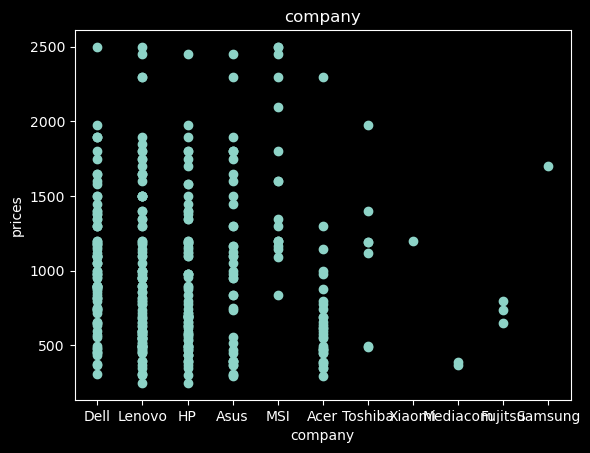

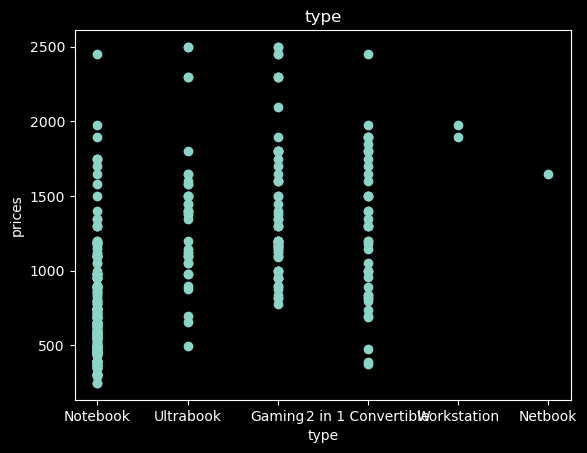

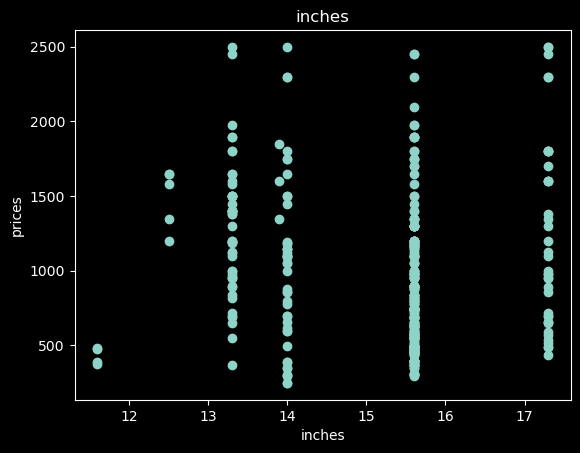

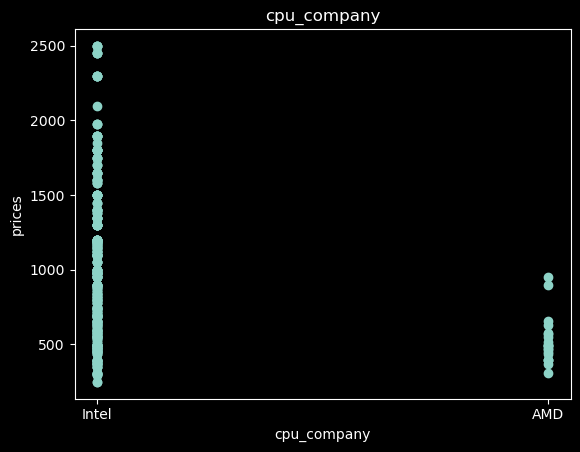

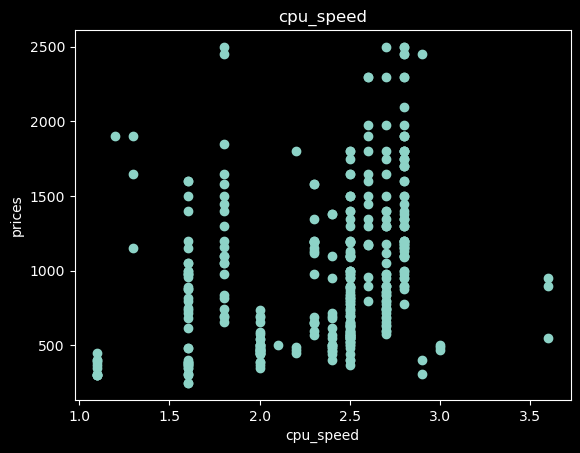

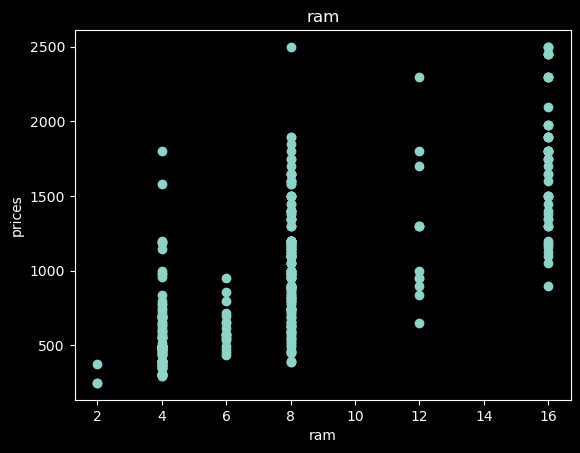

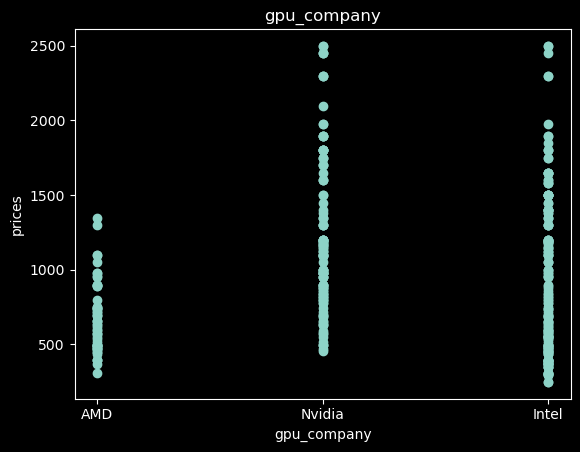

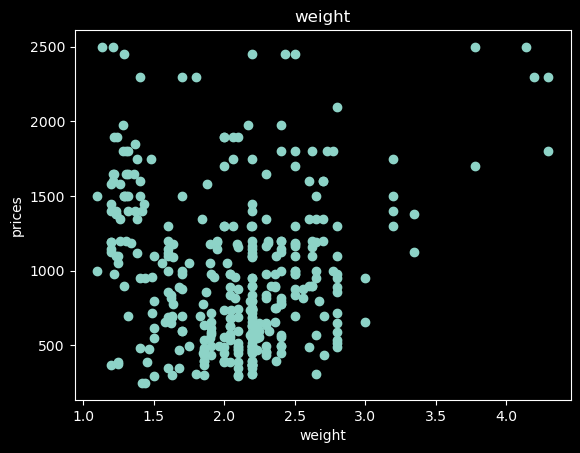

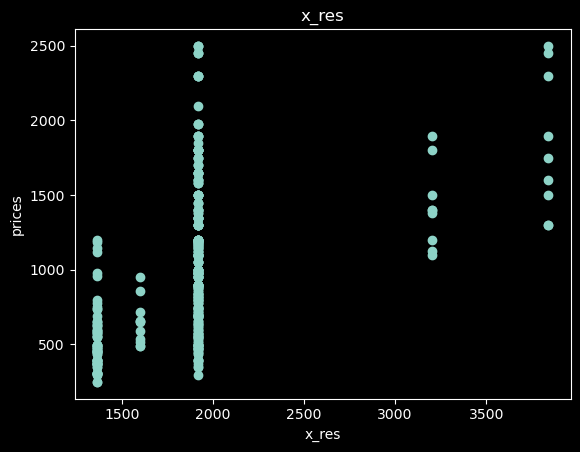

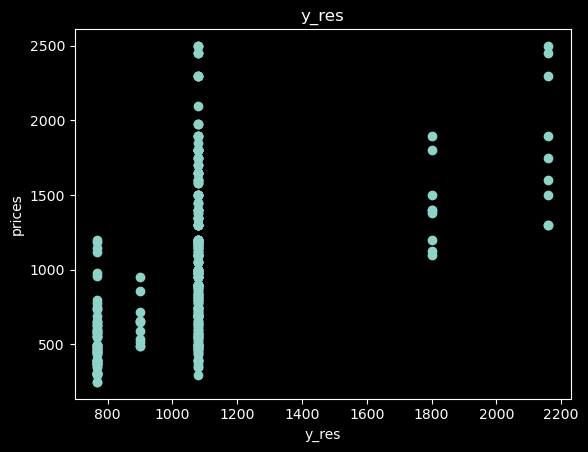

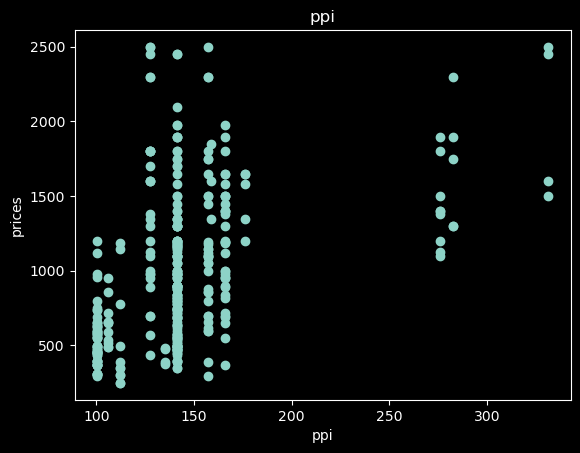

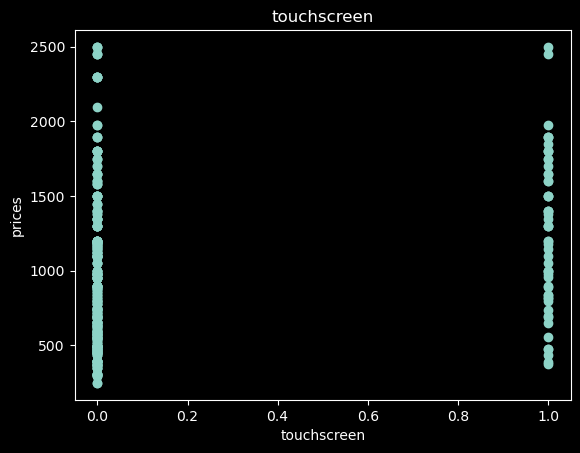

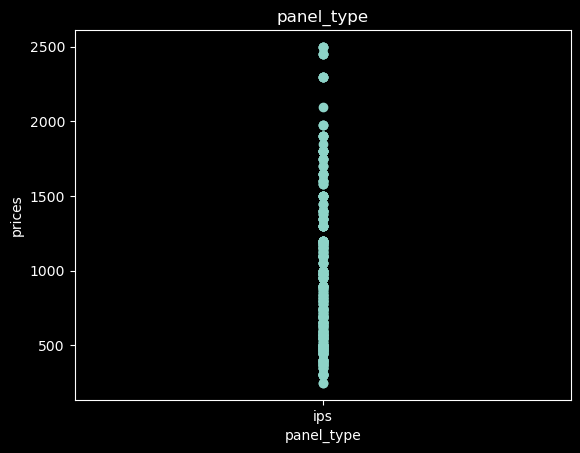

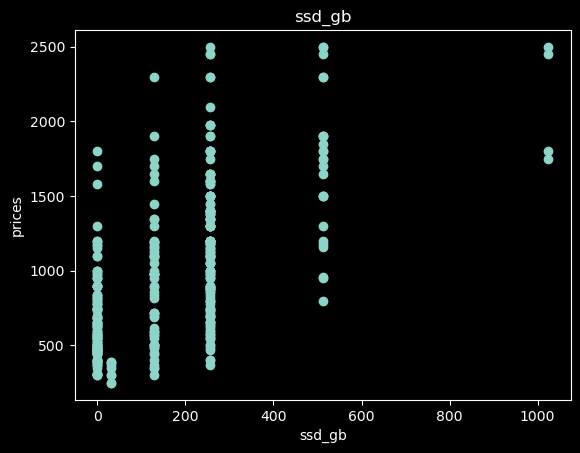

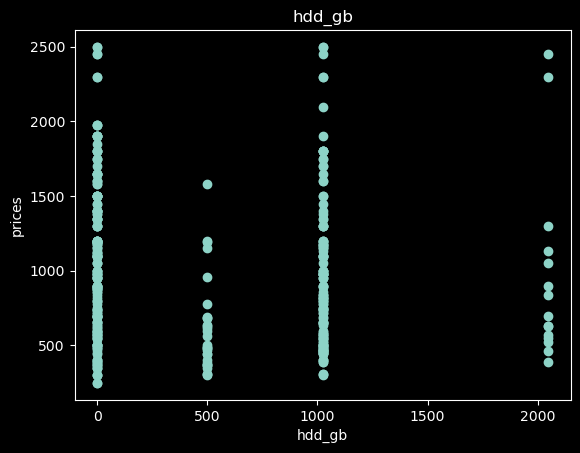

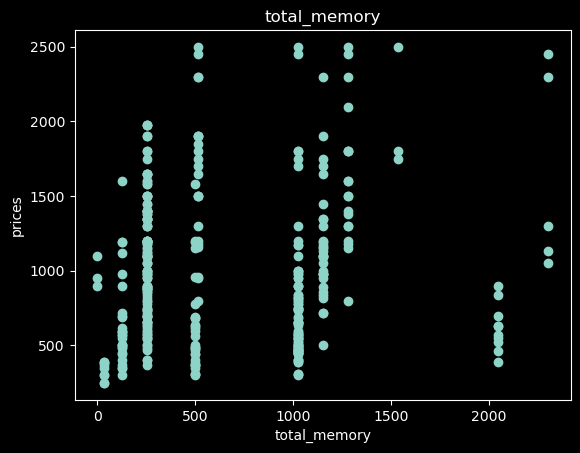

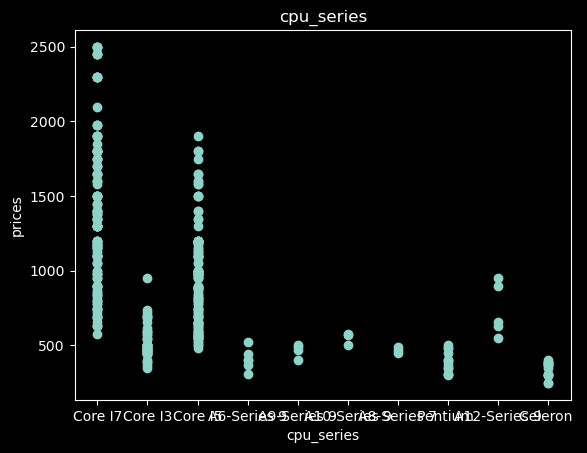

In [8159]:
for label in df_plotting.columns[:-1]:
  plt.scatter(df_plotting[label], df_plotting["price"])
  plt.title(label)
  plt.ylabel("prices")
  plt.xlabel(label)
  plt.show()

#### Remove columns that do not have a linear relationship/are weak

In [8160]:
# verify with graph
corr_matrix = df.corr(numeric_only=True)
corr_with_price = corr_matrix["price"].sort_values(ascending=False)
print(corr_with_price)

price                      1.000000
ram                        0.724726
ssd_gb                     0.612466
cpu_series_Core I7         0.583714
y_res                      0.483286
x_res                      0.483185
ppi                        0.461967
type_Gaming                0.376373
cpu_speed                  0.317983
gpu_company_Nvidia         0.315024
company_MSI                0.269634
type_Ultrabook             0.254377
touchscreen                0.223003
cpu_company_Intel          0.221109
type_Workstation           0.138308
total_memory               0.107320
company_Samsung            0.073292
type_Netbook               0.068274
company_Dell               0.067124
company_Toshiba            0.038549
company_Asus               0.038265
weight                     0.022572
company_Xiaomi             0.022087
company_Lenovo            -0.027163
company_Fujitsu           -0.045235
cpu_series_Core I5        -0.046108
cpu_series_A12-Series 9   -0.056716
company_HP                -0

In [8161]:
df = df.drop([ 'panel_type', 'weight', 'hdd_gb', 'inches'], axis=1)

## Train, valid, test dataset

In [8162]:
# randomize data
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

train = df_shuffled.iloc[:int(0.6*len(df_shuffled))]
val   = df_shuffled.iloc[int(0.6*len(df_shuffled)):int(0.8*len(df_shuffled))]
test  = df_shuffled.iloc[int(0.8*len(df_shuffled)):]


In [8163]:
# get respective xs and ys
x_train = train.drop(['price'], axis=1)
y_train = train['price']

x_val = val.drop(['price'], axis=1)
y_val = val['price']

x_test = test.drop(['price'], axis=1)
y_test = test['price']

## Models

### Simple regression with sklearn

In [8164]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

LinearRegression()

#### r^2 value

In [8165]:
lin_reg.score(x_test, y_test)

0.7606361930865693

#### plotting

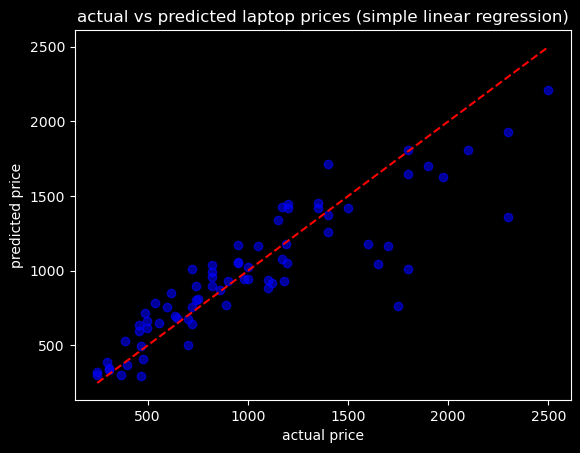

In [8166]:
y_pred_lr = lin_reg.predict(x_test)

plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.6)
plt.xlabel("actual price")
plt.ylabel("predicted price")
plt.title("actual vs predicted laptop prices (simple linear regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

#### Model performance

In [8167]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# find Coefficient of Determinations
r2_test = r2_score(y_test, y_pred_lr)

# Mean Absolute Error 
mae = mean_absolute_error(y_test, y_pred_lr)

# Mean Squared Error 
mse = mean_squared_error(y_test, y_pred_lr)

# Root Mean Squared Error
rmse = np.sqrt(mse)
print(f"R2 (Test): {r2_test:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


R2 (Test): 0.761
MAE: 181.36
MSE: 68734.37
RMSE: 262.17


### Regression with Neural Network

In [8168]:
# turn to arrays
x_train_array = x_train.to_numpy(dtype="float32")
x_val_array   = x_val.to_numpy(dtype="float32")
x_test_array  = x_test.to_numpy(dtype="float32")

y_train_array = y_train.to_numpy(dtype="float32").reshape(-1, 1)
y_val_array   = y_val.to_numpy(dtype="float32").reshape(-1, 1)
y_test_array  = y_test.to_numpy(dtype="float32").reshape(-1, 1)


#### Normalizer was not working with this dataset due to it being a smaller dataset so used a more reliable approach by using sklearns standard scaler

In [8169]:
from sklearn.preprocessing import MinMaxScaler
x_scaler = StandardScaler()

x_scaler.fit(x_train_array)

# Apply scaling
x_train_scaled = x_scaler.transform(x_train_array)
x_val_scaled = x_scaler.transform(x_val_array)
x_test_scaled = x_scaler.transform(x_test_array)



# see if it worked
print("After StandardScaler:")
print(f"Train: Mean: {x_train_scaled.mean():.6f}, Std: {x_train_scaled.std():.6f}")
print(f"Val: Mean: {x_val_scaled.mean():.6f}, Std: {x_val_scaled.std():.6f}")
print(f"Test: Mean: {x_test_scaled.mean():.6f}, Std: {x_test_scaled.std():.6f}")


After StandardScaler:
Train: Mean: -0.000000, Std: 0.985611
Val: Mean: -0.004283, Std: 0.971171
Test: Mean: 0.011975, Std: 0.927055


In [8170]:

nn_model = tf.keras.Sequential([

    tf.keras.layers.Dense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(1)
])


nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')


In [8171]:
# Train on SCALED data
history = nn_model.fit(
    x_train_scaled, y_train_array,
    validation_data=(x_val_scaled, y_val_array),
    epochs=200,
    verbose=0
)


#### Plot loss over epochs to see if trained correctly

In [8172]:

def plot_history(history):
  # Plot training & validation loss values
  plt.plot(history.history['loss'], label=' Loss')
  plt.plot(history.history['val_loss'], label='val Loss')

  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)
  plt.show()


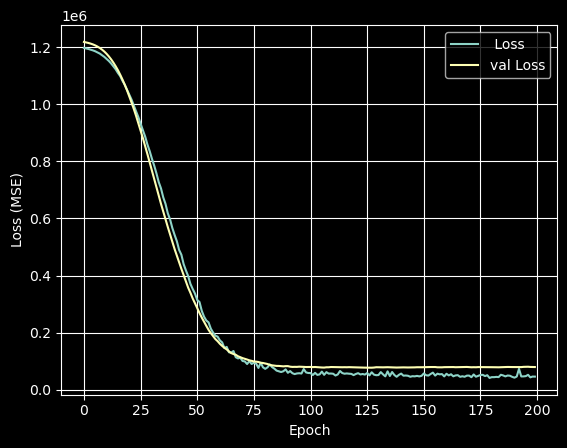

In [8173]:
plot_history(history)

#### Model performance

In [8174]:
# Evaluate on SCALED data
y_pred_nn = nn_model.predict(x_test_scaled).flatten()

def eval_split(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.3f}")

eval_split("Test", y_test_array, y_pred_nn)



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Test Metrics:
MSE: 59499.41
RMSE: 243.93
MAE: 174.64
R²: 0.793


#### Compare with sklearn lin regression through plot

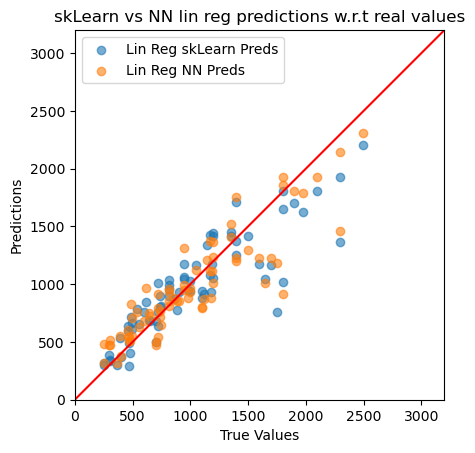

In [8178]:
ax = plt.axes(aspect='equal')
plt.title('skLearn vs NN lin reg predictions w.r.t real values')
plt.scatter(y_test, y_pred_lr, label='Lin Reg skLearn Preds', alpha=0.6)
plt.scatter(y_test, y_pred_nn, label='Lin Reg NN Preds', alpha=0.6)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0,3200]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c='red')